###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [3]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [4]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
336,Cameroon,2011,4.434,8.106,0.738,50.04,0.817,-0.038,0.870,0.608,0.272
1599,Pakistan,2009,5.208,8.315,0.522,54.24,0.388,0.069,0.874,0.516,0.349
484,Costa Rica,2017,7.225,9.912,0.922,70.00,0.936,-0.086,0.742,0.791,0.275
2100,Togo,2016,3.879,7.569,0.509,54.70,0.730,-0.031,0.815,0.610,0.483
289,Bulgaria,2021,5.422,10.102,0.884,66.50,0.841,-0.018,0.891,0.647,0.253


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [5]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [6]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [7]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [8]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [9]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\Sohin\AppData\Local\Temp\ipykernel_27584\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


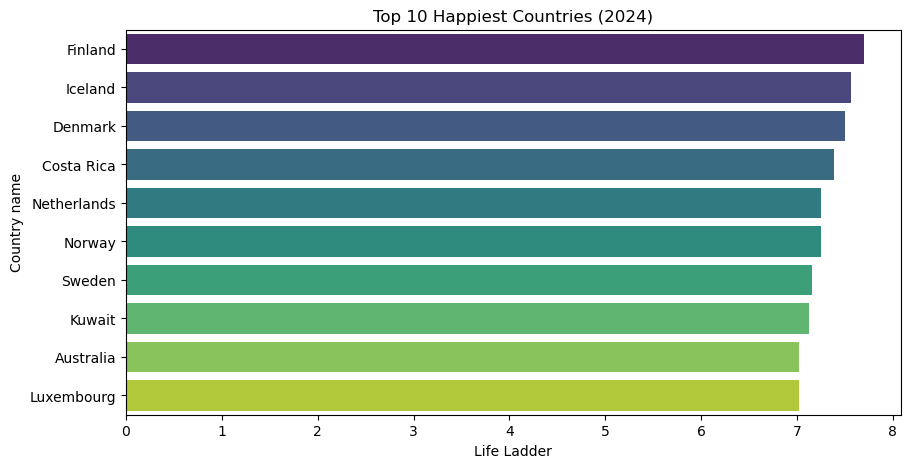

C:\Users\Sohin\AppData\Local\Temp\ipykernel_27584\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


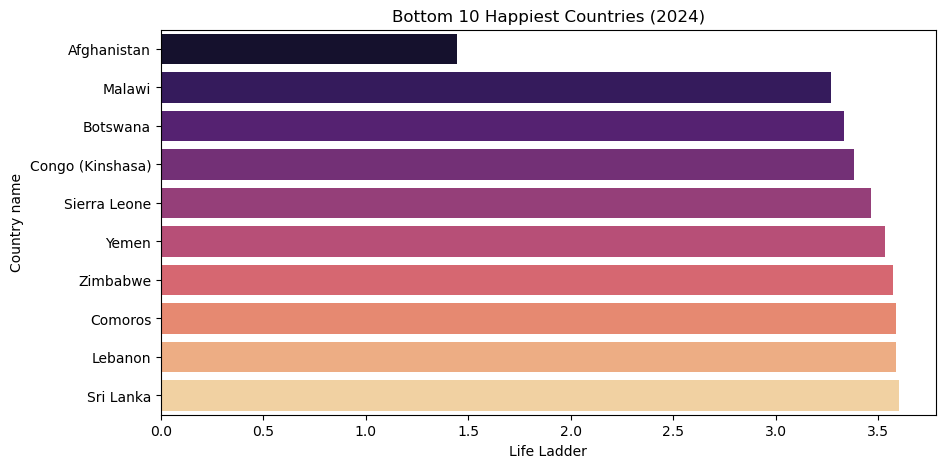

In [10]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


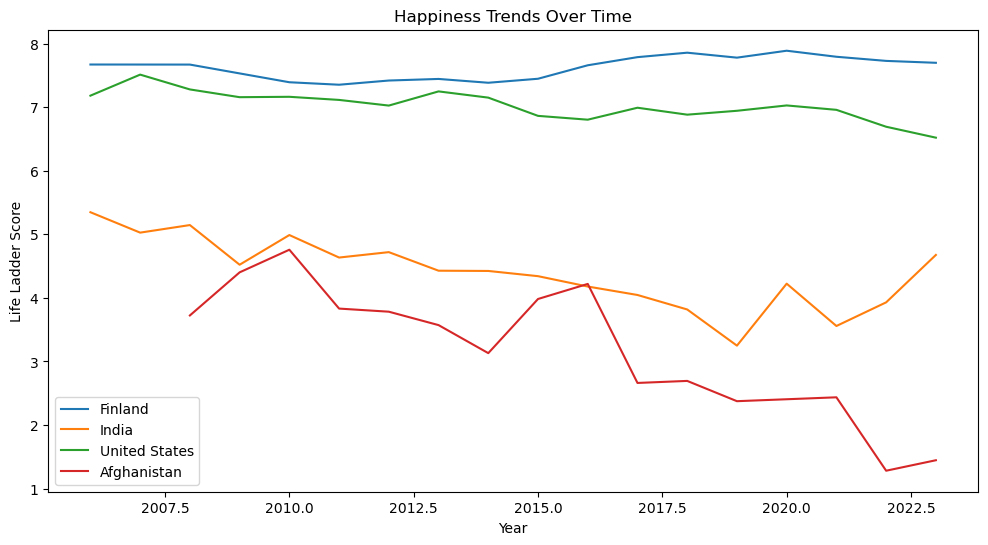

In [11]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


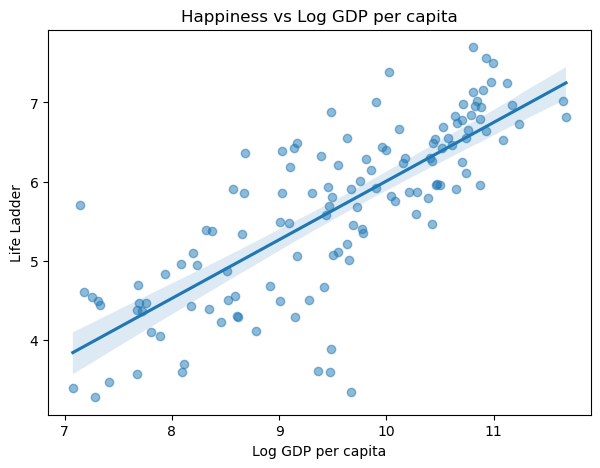

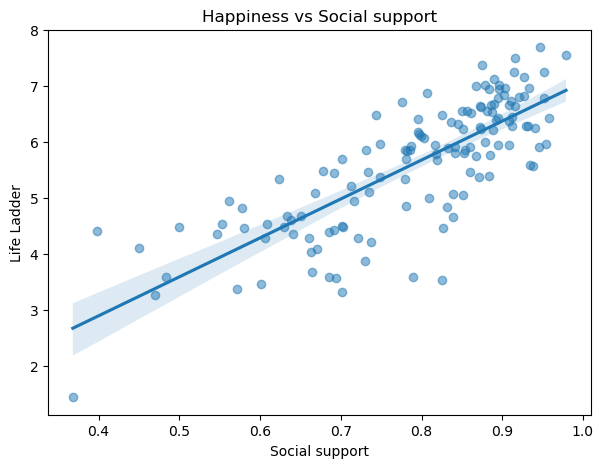

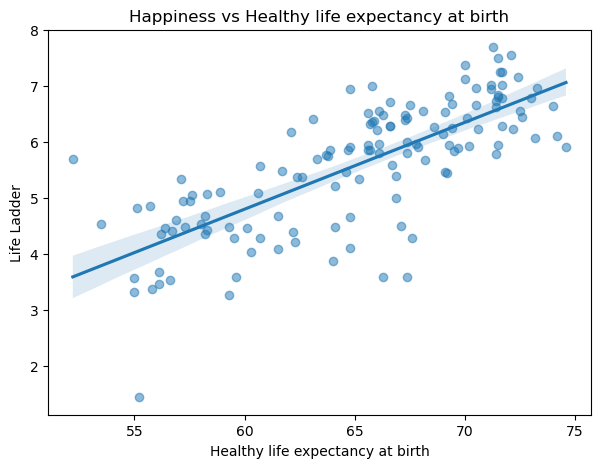

In [12]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


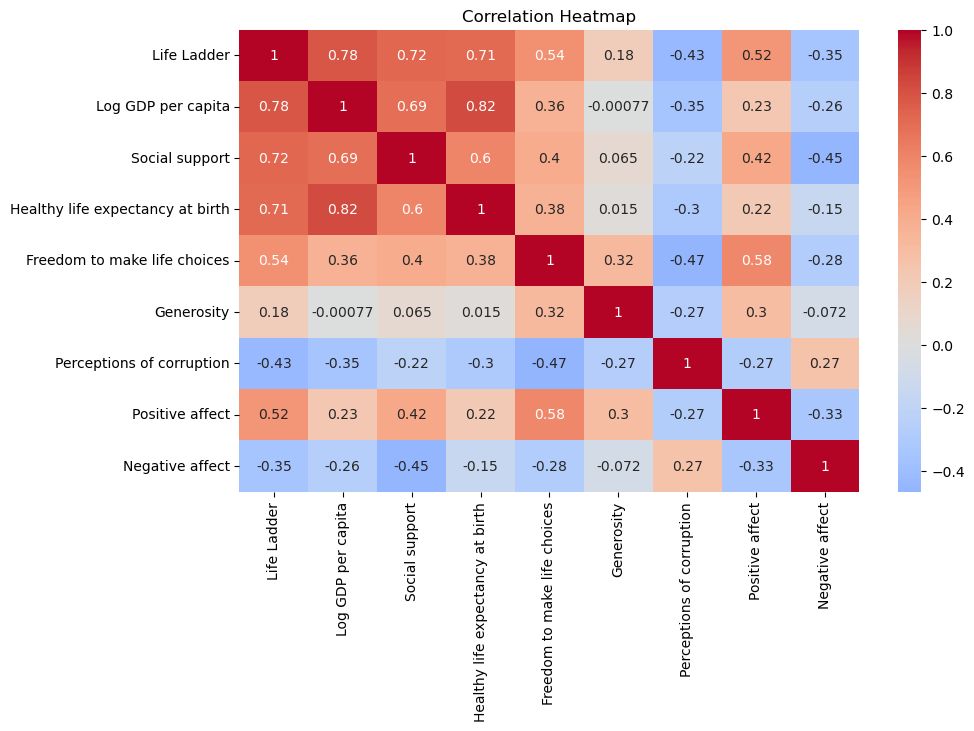

In [13]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


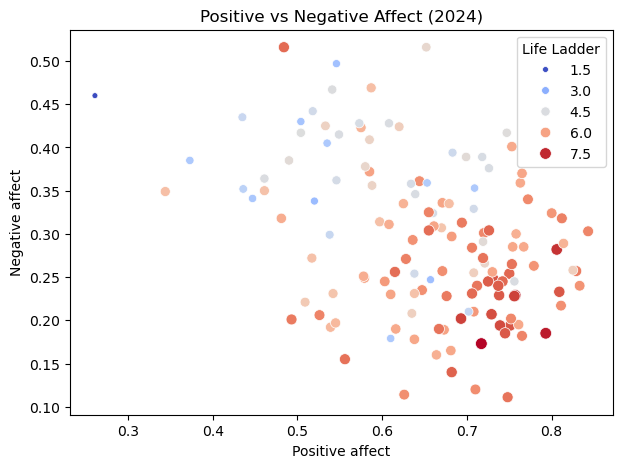

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [16]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [17]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [18]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [19]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [20]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [21]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [22]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [23]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [24]:
# data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
# data.sample(10)

data.drop('Country name', axis=1, inplace=True)

Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [25]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1725 non-null   int64  
 1   Life Ladder                       1725 non-null   float64
 2   Log GDP per capita                1725 non-null   float64
 3   Social support                    1725 non-null   float64
 4   Healthy life expectancy at birth  1725 non-null   float64
 5   Freedom to make life choices      1725 non-null   float64
 6   Generosity                        1725 non-null   float64
 7   Perceptions of corruption         1725 non-null   float64
 8   Positive affect                   1725 non-null   float64
 9   Negative affect                   1725 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 148.2 KB


In [26]:

features_train = training.drop(['Life Ladder'], axis=1)
features_test = test.drop(['Life Ladder'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


Lastly, we need to ensure that our features are scaled; log GDP and life expectancy are both relatively large numbers compared to the other features and may have disproportionate impact on the model. We fit a StandardScaler on the just training features, because otherwise the scaler acts as a "hint" to the model during training (i.e. data leaks out of the test set), then we use it to transform both the features and target.

In [27]:
# scaler = StandardScaler()
# scaler.fit(features_train)
# features_train = scaler.transform(features_train)
# features_test = scaler.transform(features_test)

In [28]:
# # For neural networks specifically, standardizing the target is often also a good idea--we can inverse transform to compare to other models
# target_scaler = StandardScaler()
# target_scaler.fit(target_train.values.reshape(-1,1))
# target_train_scaled = target_scaler.transform(target_train.values.reshape(-1,1)).flatten()
# target_test_scaled = target_scaler.transform(target_test.values.reshape(-1,1)).flatten()

# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [29]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3947212943765264

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [30]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-30 15:15:35,151] A new study created in memory with name: no-name-d30660b7-b74c-4cc9-ba98-26959586734f
[I 2025-09-30 15:15:35,370] Trial 0 finished with value: 0.36380665784033517 and parameters: {'n_estimators': 80, 'max_depth': 7}. Best is trial 0 with value: 0.36380665784033517.
[I 2025-09-30 15:15:35,426] Trial 1 finished with value: 0.3702277293848613 and parameters: {'n_estimators': 10, 'max_depth': 8}. Best is trial 0 with value: 0.36380665784033517.
[I 2025-09-30 15:15:38,408] Trial 2 finished with value: 0.3351247887762766 and parameters: {'n_estimators': 150, 'max_depth': 14}. Best is trial 2 with value: 0.3351247887762766.
[I 2025-09-30 15:15:39,082] Trial 3 finished with value: 0.34999082295856776 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 2 with value: 0.3351247887762766.
[I 2025-09-30 15:15:39,248] Trial 4 finished with value: 0.3764942148867108 and parameters: {'n_estimators': 150, 'max_depth': 6}. Best is trial 2 with value: 0.335124

In [31]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 90, 'max_depth': 15}
At trial:  26
Mean absolute error:  0.3299729511018784

Hyperparameter importances:


{'max_depth': 0.9592399783743185, 'n_estimators': 0.0407600216256814}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [32]:
from sklearn.ensemble import RandomForestRegressor

rtf = RandomForestRegressor()
rtf.fit(features_train, target_train)
rtf_pred = rtf.predict(features_test)
rtf_mae = mean_absolute_error(target_test, rtf_pred)
rtf_mae


0.33758621031746033

In [33]:
from sklearn.tree import DecisionTreeRegressor

dtr= DecisionTreeRegressor()
dtr.fit(features_train, target_train)
dtr_pred = rtf.predict(features_test)
dtr_mae = mean_absolute_error(target_test, dtr_pred)
dtr_mae


0.33758621031746033

In [34]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(features_train, target_train)
lgbm_pred = lgbm.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, lgbm_pred)
lgbm_mae

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

0.32155635237480695

In [35]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor()
cbr.fit(features_train, target_train)
cbr_pred = cbr.predict(features_test)
cbr_mae = mean_absolute_error(target_test, cbr_pred)
cbr_mae

Learning rate set to 0.044626
0:	learn: 1.0948076	total: 139ms	remaining: 2m 18s
1:	learn: 1.0603695	total: 141ms	remaining: 1m 10s
2:	learn: 1.0276068	total: 145ms	remaining: 48.2s
3:	learn: 0.9969302	total: 148ms	remaining: 36.8s
4:	learn: 0.9677158	total: 151ms	remaining: 30s
5:	learn: 0.9407344	total: 153ms	remaining: 25.3s
6:	learn: 0.9142003	total: 156ms	remaining: 22.2s
7:	learn: 0.8899628	total: 159ms	remaining: 19.7s
8:	learn: 0.8662062	total: 161ms	remaining: 17.7s
9:	learn: 0.8423363	total: 163ms	remaining: 16.2s
10:	learn: 0.8198180	total: 166ms	remaining: 14.9s
11:	learn: 0.8005310	total: 169ms	remaining: 13.9s
12:	learn: 0.7803021	total: 172ms	remaining: 13.1s
13:	learn: 0.7611693	total: 175ms	remaining: 12.3s
14:	learn: 0.7430790	total: 177ms	remaining: 11.6s
15:	learn: 0.7261684	total: 180ms	remaining: 11.1s
16:	learn: 0.7108020	total: 183ms	remaining: 10.6s
17:	learn: 0.6956628	total: 186ms	remaining: 10.1s
18:	learn: 0.6811953	total: 188ms	remaining: 9.7s
19:	learn: 0

0.3189764501039697

## The lowest mean absolute error was achieved by cat boost regressor model followed by light gbm regressor. Decision tree and random forest regressor gave similar mae.

In [36]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-30 15:16:25,869] A new study created in memory with name: no-name-32f3b656-ff01-4a9f-92d1-d924095d4e25


Learning rate set to 0.234399
0:	learn: 0.9659914	total: 157ms	remaining: 20.2s
1:	learn: 0.8265606	total: 315ms	remaining: 20.2s
2:	learn: 0.7252984	total: 474ms	remaining: 20.1s
3:	learn: 0.6420117	total: 636ms	remaining: 20s
4:	learn: 0.5752603	total: 799ms	remaining: 20s
5:	learn: 0.5223321	total: 964ms	remaining: 19.9s
6:	learn: 0.4799857	total: 1.13s	remaining: 19.9s
7:	learn: 0.4441858	total: 1.3s	remaining: 19.8s
8:	learn: 0.4128682	total: 1.47s	remaining: 19.7s
9:	learn: 0.3865207	total: 1.63s	remaining: 19.6s
10:	learn: 0.3649312	total: 1.79s	remaining: 19.4s
11:	learn: 0.3456221	total: 1.95s	remaining: 19.2s
12:	learn: 0.3281280	total: 2.12s	remaining: 19s
13:	learn: 0.3132567	total: 2.28s	remaining: 18.9s
14:	learn: 0.2997755	total: 2.44s	remaining: 18.7s
15:	learn: 0.2881056	total: 2.61s	remaining: 18.6s
16:	learn: 0.2783475	total: 2.76s	remaining: 18.3s
17:	learn: 0.2680578	total: 2.92s	remaining: 18.2s
18:	learn: 0.2592097	total: 3.09s	remaining: 18.1s
19:	learn: 0.24995

[I 2025-09-30 15:16:50,337] Trial 0 finished with value: 0.3492940615972645 and parameters: {'n_estimators': 130, 'max_depth': 14}. Best is trial 0 with value: 0.3492940615972645.
[I 2025-09-30 15:16:50,517] Trial 1 finished with value: 0.3577803441069981 and parameters: {'n_estimators': 40, 'max_depth': 6}. Best is trial 0 with value: 0.3492940615972645.


Learning rate set to 0.5
0:	learn: 0.7516215	total: 3.96ms	remaining: 154ms
1:	learn: 0.5889967	total: 6.15ms	remaining: 117ms
2:	learn: 0.5228377	total: 8.94ms	remaining: 110ms
3:	learn: 0.4899693	total: 14.5ms	remaining: 131ms
4:	learn: 0.4693582	total: 17.5ms	remaining: 122ms
5:	learn: 0.4600491	total: 20.1ms	remaining: 114ms
6:	learn: 0.4472488	total: 24.9ms	remaining: 117ms
7:	learn: 0.4399187	total: 28.4ms	remaining: 113ms
8:	learn: 0.4331871	total: 33.4ms	remaining: 115ms
9:	learn: 0.4289131	total: 36ms	remaining: 108ms
10:	learn: 0.4241053	total: 38.9ms	remaining: 102ms
11:	learn: 0.4200592	total: 41.4ms	remaining: 96.5ms
12:	learn: 0.4162564	total: 44.7ms	remaining: 92.8ms
13:	learn: 0.4083094	total: 48ms	remaining: 89.2ms
14:	learn: 0.4022687	total: 51.1ms	remaining: 85.2ms
15:	learn: 0.3965128	total: 53.4ms	remaining: 80.1ms
16:	learn: 0.3885071	total: 55.7ms	remaining: 75.3ms
17:	learn: 0.3842665	total: 57.8ms	remaining: 70.6ms
18:	learn: 0.3796432	total: 59.9ms	remaining: 

[I 2025-09-30 15:17:00,264] Trial 2 finished with value: 0.3556541438822616 and parameters: {'n_estimators': 90, 'max_depth': 13}. Best is trial 0 with value: 0.3492940615972645.


88:	learn: 0.0445276	total: 9.48s	remaining: 107ms
89:	learn: 0.0435126	total: 9.58s	remaining: 0us


[I 2025-09-30 15:17:00,452] Trial 3 finished with value: 0.35039417750062907 and parameters: {'n_estimators': 180, 'max_depth': 2}. Best is trial 0 with value: 0.3492940615972645.


Learning rate set to 0.17991
0:	learn: 1.0107277	total: 621us	remaining: 111ms
1:	learn: 0.9089083	total: 1.19ms	remaining: 106ms
2:	learn: 0.8349404	total: 1.59ms	remaining: 94.1ms
3:	learn: 0.7693085	total: 2.47ms	remaining: 109ms
4:	learn: 0.7231004	total: 3.01ms	remaining: 106ms
5:	learn: 0.6809743	total: 4.11ms	remaining: 119ms
6:	learn: 0.6458824	total: 5.07ms	remaining: 125ms
7:	learn: 0.6174991	total: 5.75ms	remaining: 124ms
8:	learn: 0.5970840	total: 6.34ms	remaining: 121ms
9:	learn: 0.5797897	total: 7.15ms	remaining: 122ms
10:	learn: 0.5640584	total: 7.86ms	remaining: 121ms
11:	learn: 0.5519345	total: 8.98ms	remaining: 126ms
12:	learn: 0.5388860	total: 9.54ms	remaining: 123ms
13:	learn: 0.5299488	total: 10.4ms	remaining: 123ms
14:	learn: 0.5234237	total: 11ms	remaining: 121ms
15:	learn: 0.5181422	total: 11.6ms	remaining: 118ms
16:	learn: 0.5133037	total: 12.2ms	remaining: 117ms
17:	learn: 0.5101991	total: 12.7ms	remaining: 115ms
18:	learn: 0.5056626	total: 13.8ms	remaining: 1

[I 2025-09-30 15:17:00,533] Trial 4 finished with value: 0.3731281635844609 and parameters: {'n_estimators': 20, 'max_depth': 4}. Best is trial 0 with value: 0.3492940615972645.


18:	learn: 0.4280441	total: 24.1ms	remaining: 1.27ms
19:	learn: 0.4230614	total: 27.9ms	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9809241	total: 9.58ms	remaining: 1.62s
1:	learn: 0.8582117	total: 16.7ms	remaining: 1.4s
2:	learn: 0.7649454	total: 24.5ms	remaining: 1.36s
3:	learn: 0.6905205	total: 35.9ms	remaining: 1.49s
4:	learn: 0.6282520	total: 46.4ms	remaining: 1.53s
5:	learn: 0.5798784	total: 56.7ms	remaining: 1.55s
6:	learn: 0.5395266	total: 64.4ms	remaining: 1.5s
7:	learn: 0.5056919	total: 72.6ms	remaining: 1.47s
8:	learn: 0.4805104	total: 83.1ms	remaining: 1.49s
9:	learn: 0.4609156	total: 110ms	remaining: 1.76s
10:	learn: 0.4428231	total: 123ms	remaining: 1.78s
11:	learn: 0.4294061	total: 134ms	remaining: 1.77s
12:	learn: 0.4194121	total: 144ms	remaining: 1.73s
13:	learn: 0.4084466	total: 154ms	remaining: 1.72s
14:	learn: 0.4006799	total: 162ms	remaining: 1.68s
15:	learn: 0.3921431	total: 172ms	remaining: 1.65s
16:	learn: 0.3864818	total: 181ms	remaining: 1.63s
17:

[I 2025-09-30 15:17:02,276] Trial 5 finished with value: 0.33028538860058815 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 5 with value: 0.33028538860058815.


169:	learn: 0.1044912	total: 1.62s	remaining: 0us
Learning rate set to 0.172173
0:	learn: 0.9887945	total: 3.68ms	remaining: 696ms
1:	learn: 0.8827053	total: 6.68ms	remaining: 628ms
2:	learn: 0.7921738	total: 9.87ms	remaining: 615ms
3:	learn: 0.7183683	total: 13.2ms	remaining: 613ms
4:	learn: 0.6623626	total: 16.5ms	remaining: 612ms
5:	learn: 0.6149887	total: 19.4ms	remaining: 595ms
6:	learn: 0.5805821	total: 22.3ms	remaining: 583ms
7:	learn: 0.5497715	total: 25.3ms	remaining: 575ms
8:	learn: 0.5254503	total: 29.4ms	remaining: 590ms
9:	learn: 0.5009587	total: 34.9ms	remaining: 628ms
10:	learn: 0.4861195	total: 38.1ms	remaining: 620ms
11:	learn: 0.4738133	total: 41.4ms	remaining: 614ms
12:	learn: 0.4629112	total: 45ms	remaining: 612ms
13:	learn: 0.4543521	total: 49.1ms	remaining: 617ms
14:	learn: 0.4460047	total: 53.7ms	remaining: 626ms
15:	learn: 0.4401046	total: 57ms	remaining: 620ms
16:	learn: 0.4357195	total: 60.4ms	remaining: 614ms
17:	learn: 0.4294089	total: 64.1ms	remaining: 613m

[I 2025-09-30 15:17:03,029] Trial 6 finished with value: 0.31293774365723487 and parameters: {'n_estimators': 190, 'max_depth': 7}. Best is trial 6 with value: 0.31293774365723487.


154:	learn: 0.1871098	total: 542ms	remaining: 122ms
155:	learn: 0.1865906	total: 546ms	remaining: 119ms
156:	learn: 0.1860097	total: 549ms	remaining: 115ms
157:	learn: 0.1851163	total: 552ms	remaining: 112ms
158:	learn: 0.1845168	total: 558ms	remaining: 109ms
159:	learn: 0.1837066	total: 562ms	remaining: 105ms
160:	learn: 0.1831754	total: 565ms	remaining: 102ms
161:	learn: 0.1827419	total: 568ms	remaining: 98.2ms
162:	learn: 0.1821674	total: 572ms	remaining: 94.8ms
163:	learn: 0.1811988	total: 576ms	remaining: 91.3ms
164:	learn: 0.1806942	total: 579ms	remaining: 87.8ms
165:	learn: 0.1801695	total: 583ms	remaining: 84.2ms
166:	learn: 0.1795256	total: 586ms	remaining: 80.7ms
167:	learn: 0.1784714	total: 589ms	remaining: 77.1ms
168:	learn: 0.1774878	total: 592ms	remaining: 73.6ms
169:	learn: 0.1761176	total: 596ms	remaining: 70.1ms
170:	learn: 0.1754217	total: 599ms	remaining: 66.5ms
171:	learn: 0.1747804	total: 602ms	remaining: 63ms
172:	learn: 0.1742970	total: 605ms	remaining: 59.5ms
17

[I 2025-09-30 15:17:03,196] Trial 7 pruned. 


12:	learn: 0.4283689	total: 23.4ms	remaining: 66.6ms
13:	learn: 0.4218474	total: 25.3ms	remaining: 64.9ms
14:	learn: 0.4188382	total: 28.8ms	remaining: 67.3ms
15:	learn: 0.4146907	total: 31.1ms	remaining: 66.2ms
16:	learn: 0.4081602	total: 32.8ms	remaining: 63.7ms
17:	learn: 0.4045101	total: 34.7ms	remaining: 61.7ms
18:	learn: 0.4003615	total: 36.4ms	remaining: 59.5ms
19:	learn: 0.3968464	total: 38.1ms	remaining: 57.2ms
20:	learn: 0.3953943	total: 39.7ms	remaining: 54.8ms
21:	learn: 0.3895696	total: 41.2ms	remaining: 52.4ms
22:	learn: 0.3857795	total: 43ms	remaining: 50.4ms
23:	learn: 0.3793938	total: 44.8ms	remaining: 48.6ms
24:	learn: 0.3740040	total: 47ms	remaining: 47ms
25:	learn: 0.3676722	total: 48.8ms	remaining: 45ms
26:	learn: 0.3631091	total: 50.3ms	remaining: 42.8ms
27:	learn: 0.3603077	total: 52.5ms	remaining: 41.3ms
28:	learn: 0.3564197	total: 54.3ms	remaining: 39.3ms
29:	learn: 0.3549508	total: 56ms	remaining: 37.3ms
30:	learn: 0.3503548	total: 57.7ms	remaining: 35.4ms
31:

[I 2025-09-30 15:17:03,340] Trial 8 pruned. 


87:	learn: 0.4218051	total: 57.8ms	remaining: 14.4ms
88:	learn: 0.4212365	total: 59.6ms	remaining: 14.1ms
89:	learn: 0.4204701	total: 60.5ms	remaining: 13.5ms
90:	learn: 0.4196111	total: 61.2ms	remaining: 12.8ms
91:	learn: 0.4191635	total: 61.9ms	remaining: 12.1ms
92:	learn: 0.4186939	total: 63ms	remaining: 11.5ms
93:	learn: 0.4184627	total: 63.6ms	remaining: 10.8ms
94:	learn: 0.4183197	total: 64.1ms	remaining: 10.1ms
95:	learn: 0.4178970	total: 64.8ms	remaining: 9.44ms
96:	learn: 0.4167508	total: 65.2ms	remaining: 8.74ms
97:	learn: 0.4164446	total: 66.1ms	remaining: 8.09ms
98:	learn: 0.4157902	total: 66.7ms	remaining: 7.41ms
99:	learn: 0.4151861	total: 67.2ms	remaining: 6.72ms
100:	learn: 0.4146987	total: 67.8ms	remaining: 6.04ms
101:	learn: 0.4143419	total: 68.4ms	remaining: 5.37ms
102:	learn: 0.4140458	total: 69.1ms	remaining: 4.69ms
103:	learn: 0.4135705	total: 69.7ms	remaining: 4.02ms
104:	learn: 0.4131162	total: 70.3ms	remaining: 3.35ms
105:	learn: 0.4129252	total: 70.9ms	remaini

[I 2025-09-30 15:17:18,573] Trial 9 finished with value: 0.3474545062652256 and parameters: {'n_estimators': 140, 'max_depth': 13}. Best is trial 6 with value: 0.31293774365723487.


139:	learn: 0.0334047	total: 15s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 0.9991454	total: 7.39ms	remaining: 1.47s
1:	learn: 0.8880691	total: 14.7ms	remaining: 1.45s
2:	learn: 0.8025613	total: 23.9ms	remaining: 1.57s
3:	learn: 0.7304798	total: 34.3ms	remaining: 1.68s
4:	learn: 0.6672981	total: 44.9ms	remaining: 1.75s
5:	learn: 0.6167233	total: 55.9ms	remaining: 1.81s
6:	learn: 0.5749389	total: 66.4ms	remaining: 1.83s
7:	learn: 0.5387172	total: 77.2ms	remaining: 1.85s
8:	learn: 0.5108638	total: 88ms	remaining: 1.87s
9:	learn: 0.4909578	total: 97.6ms	remaining: 1.85s
10:	learn: 0.4712227	total: 108ms	remaining: 1.85s
11:	learn: 0.4559346	total: 118ms	remaining: 1.85s
12:	learn: 0.4451118	total: 128ms	remaining: 1.83s
13:	learn: 0.4309665	total: 137ms	remaining: 1.82s
14:	learn: 0.4206428	total: 148ms	remaining: 1.82s
15:	learn: 0.4129104	total: 157ms	remaining: 1.81s
16:	learn: 0.4048254	total: 169ms	remaining: 1.82s
17:	learn: 0.3980810	total: 179ms	remaining: 1.81s
18:	le

[I 2025-09-30 15:17:20,737] Trial 10 finished with value: 0.3268012610946338 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 6 with value: 0.31293774365723487.


187:	learn: 0.1073076	total: 1.9s	remaining: 121ms
188:	learn: 0.1061903	total: 1.91s	remaining: 111ms
189:	learn: 0.1053873	total: 1.92s	remaining: 101ms
190:	learn: 0.1044943	total: 1.93s	remaining: 91ms
191:	learn: 0.1036808	total: 1.94s	remaining: 80.9ms
192:	learn: 0.1029238	total: 1.95s	remaining: 70.8ms
193:	learn: 0.1024950	total: 1.96s	remaining: 60.6ms
194:	learn: 0.1019152	total: 1.97s	remaining: 50.5ms
195:	learn: 0.1012856	total: 1.98s	remaining: 40.4ms
196:	learn: 0.1002188	total: 1.99s	remaining: 30.3ms
197:	learn: 0.0995901	total: 2s	remaining: 20.2ms
198:	learn: 0.0991423	total: 2.01s	remaining: 10.1ms
199:	learn: 0.0984045	total: 2.01s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 0.9991454	total: 8.07ms	remaining: 1.6s
1:	learn: 0.8880691	total: 15.9ms	remaining: 1.58s
2:	learn: 0.8025613	total: 27.6ms	remaining: 1.81s
3:	learn: 0.7304798	total: 38.6ms	remaining: 1.89s
4:	learn: 0.6672981	total: 48.3ms	remaining: 1.88s
5:	learn: 0.6167233	total: 58.8ms	remai

[I 2025-09-30 15:17:22,774] Trial 11 finished with value: 0.3268012610946338 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 6 with value: 0.31293774365723487.


198:	learn: 0.0991423	total: 1.88s	remaining: 9.47ms
199:	learn: 0.0984045	total: 1.89s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0017204	total: 16.6ms	remaining: 3.31s
1:	learn: 0.8942221	total: 32.3ms	remaining: 3.2s
2:	learn: 0.8089802	total: 49.3ms	remaining: 3.23s
3:	learn: 0.7315020	total: 69.3ms	remaining: 3.39s
4:	learn: 0.6665346	total: 88.6ms	remaining: 3.45s
5:	learn: 0.6147266	total: 110ms	remaining: 3.55s
6:	learn: 0.5737196	total: 130ms	remaining: 3.57s
7:	learn: 0.5398097	total: 149ms	remaining: 3.57s
8:	learn: 0.5116886	total: 168ms	remaining: 3.57s
9:	learn: 0.4882957	total: 186ms	remaining: 3.54s
10:	learn: 0.4651411	total: 204ms	remaining: 3.51s
11:	learn: 0.4477900	total: 223ms	remaining: 3.5s
12:	learn: 0.4303413	total: 240ms	remaining: 3.46s
13:	learn: 0.4154166	total: 260ms	remaining: 3.45s
14:	learn: 0.4059234	total: 281ms	remaining: 3.46s
15:	learn: 0.3946790	total: 301ms	remaining: 3.46s
16:	learn: 0.3849445	total: 320ms	remaining: 3.44s
17:	lea

[I 2025-09-30 15:17:26,330] Trial 12 finished with value: 0.3336887510534388 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 6 with value: 0.31293774365723487.


195:	learn: 0.0784107	total: 3.35s	remaining: 68.3ms
196:	learn: 0.0773475	total: 3.36s	remaining: 51.2ms
197:	learn: 0.0770104	total: 3.38s	remaining: 34.1ms
198:	learn: 0.0764827	total: 3.39s	remaining: 17ms
199:	learn: 0.0760278	total: 3.41s	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9680232	total: 3.54ms	remaining: 564ms
1:	learn: 0.8517943	total: 8ms	remaining: 632ms
2:	learn: 0.7546957	total: 11.1ms	remaining: 580ms
3:	learn: 0.6796390	total: 14.3ms	remaining: 557ms
4:	learn: 0.6240263	total: 17.8ms	remaining: 552ms
5:	learn: 0.5793042	total: 21.5ms	remaining: 551ms
6:	learn: 0.5453896	total: 24.8ms	remaining: 541ms
7:	learn: 0.5195576	total: 27.6ms	remaining: 524ms
8:	learn: 0.4982152	total: 31ms	remaining: 519ms
9:	learn: 0.4791946	total: 35.7ms	remaining: 535ms
10:	learn: 0.4659710	total: 41ms	remaining: 556ms
11:	learn: 0.4566746	total: 44.5ms	remaining: 549ms
12:	learn: 0.4472022	total: 48.6ms	remaining: 549ms
13:	learn: 0.4395736	total: 55.1ms	remaining: 575ms


[I 2025-09-30 15:17:26,971] Trial 13 finished with value: 0.323979929190621 and parameters: {'n_estimators': 160, 'max_depth': 7}. Best is trial 6 with value: 0.31293774365723487.


132:	learn: 0.1972288	total: 472ms	remaining: 95.8ms
133:	learn: 0.1964999	total: 476ms	remaining: 92.3ms
134:	learn: 0.1953537	total: 479ms	remaining: 88.7ms
135:	learn: 0.1944509	total: 482ms	remaining: 85.1ms
136:	learn: 0.1937030	total: 485ms	remaining: 81.4ms
137:	learn: 0.1933751	total: 488ms	remaining: 77.8ms
138:	learn: 0.1920177	total: 491ms	remaining: 74.2ms
139:	learn: 0.1903639	total: 494ms	remaining: 70.6ms
140:	learn: 0.1889323	total: 498ms	remaining: 67.1ms
141:	learn: 0.1879596	total: 502ms	remaining: 63.6ms
142:	learn: 0.1874965	total: 505ms	remaining: 60ms
143:	learn: 0.1851823	total: 508ms	remaining: 56.5ms
144:	learn: 0.1846505	total: 511ms	remaining: 52.9ms
145:	learn: 0.1839160	total: 514ms	remaining: 49.3ms
146:	learn: 0.1827548	total: 517ms	remaining: 45.8ms
147:	learn: 0.1820081	total: 521ms	remaining: 42.2ms
148:	learn: 0.1808801	total: 524ms	remaining: 38.7ms
149:	learn: 0.1803408	total: 527ms	remaining: 35.1ms
150:	learn: 0.1795792	total: 530ms	remaining: 31

[I 2025-09-30 15:17:27,623] Trial 14 finished with value: 0.323979929190621 and parameters: {'n_estimators': 160, 'max_depth': 7}. Best is trial 6 with value: 0.31293774365723487.


122:	learn: 0.2070892	total: 435ms	remaining: 131ms
123:	learn: 0.2063493	total: 439ms	remaining: 127ms
124:	learn: 0.2056035	total: 442ms	remaining: 124ms
125:	learn: 0.2048135	total: 445ms	remaining: 120ms
126:	learn: 0.2035463	total: 448ms	remaining: 117ms
127:	learn: 0.2022838	total: 452ms	remaining: 113ms
128:	learn: 0.2016288	total: 456ms	remaining: 109ms
129:	learn: 0.2004624	total: 459ms	remaining: 106ms
130:	learn: 0.1981954	total: 462ms	remaining: 102ms
131:	learn: 0.1978369	total: 466ms	remaining: 98.8ms
132:	learn: 0.1972288	total: 469ms	remaining: 95.2ms
133:	learn: 0.1964999	total: 473ms	remaining: 91.7ms
134:	learn: 0.1953537	total: 476ms	remaining: 88.1ms
135:	learn: 0.1944509	total: 479ms	remaining: 84.6ms
136:	learn: 0.1937030	total: 483ms	remaining: 81ms
137:	learn: 0.1933751	total: 486ms	remaining: 77.5ms
138:	learn: 0.1920177	total: 489ms	remaining: 73.9ms
139:	learn: 0.1903639	total: 493ms	remaining: 70.4ms
140:	learn: 0.1889323	total: 497ms	remaining: 66.9ms
141:

[I 2025-09-30 15:17:27,956] Trial 15 finished with value: 0.32494913240553214 and parameters: {'n_estimators': 150, 'max_depth': 5}. Best is trial 6 with value: 0.31293774365723487.


116:	learn: 0.2880053	total: 200ms	remaining: 56.5ms
117:	learn: 0.2868542	total: 202ms	remaining: 54.8ms
118:	learn: 0.2845465	total: 204ms	remaining: 53.1ms
119:	learn: 0.2840945	total: 206ms	remaining: 51.4ms
120:	learn: 0.2822908	total: 207ms	remaining: 49.7ms
121:	learn: 0.2819556	total: 209ms	remaining: 47.9ms
122:	learn: 0.2806255	total: 210ms	remaining: 46.2ms
123:	learn: 0.2788864	total: 212ms	remaining: 44.4ms
124:	learn: 0.2780899	total: 213ms	remaining: 42.7ms
125:	learn: 0.2775023	total: 215ms	remaining: 41ms
126:	learn: 0.2769408	total: 217ms	remaining: 39.2ms
127:	learn: 0.2761503	total: 218ms	remaining: 37.5ms
128:	learn: 0.2752597	total: 220ms	remaining: 35.8ms
129:	learn: 0.2743074	total: 221ms	remaining: 34.1ms
130:	learn: 0.2727779	total: 223ms	remaining: 32.3ms
131:	learn: 0.2714923	total: 225ms	remaining: 30.6ms
132:	learn: 0.2707096	total: 226ms	remaining: 28.9ms
133:	learn: 0.2695476	total: 228ms	remaining: 27.2ms
134:	learn: 0.2681125	total: 229ms	remaining: 25

[I 2025-09-30 15:17:30,876] Trial 16 pruned. 


85:	learn: 0.0739086	total: 2.69s	remaining: 125ms
86:	learn: 0.0731452	total: 2.72s	remaining: 93.9ms
87:	learn: 0.0719152	total: 2.75s	remaining: 62.5ms
88:	learn: 0.0710156	total: 2.78s	remaining: 31.2ms
89:	learn: 0.0702875	total: 2.81s	remaining: 0us
Learning rate set to 0.25016
0:	learn: 0.9266391	total: 4.8ms	remaining: 572ms
1:	learn: 0.7883408	total: 8.57ms	remaining: 506ms
2:	learn: 0.6879792	total: 12ms	remaining: 466ms
3:	learn: 0.6126666	total: 16.5ms	remaining: 478ms
4:	learn: 0.5621870	total: 22.9ms	remaining: 528ms
5:	learn: 0.5227601	total: 27.5ms	remaining: 522ms
6:	learn: 0.4989269	total: 32.6ms	remaining: 526ms
7:	learn: 0.4801734	total: 36.5ms	remaining: 510ms
8:	learn: 0.4605141	total: 39.8ms	remaining: 491ms
9:	learn: 0.4497169	total: 45.1ms	remaining: 497ms
10:	learn: 0.4418350	total: 48.9ms	remaining: 485ms
11:	learn: 0.4326239	total: 52.1ms	remaining: 469ms
12:	learn: 0.4264157	total: 56.3ms	remaining: 463ms
13:	learn: 0.4210165	total: 60.6ms	remaining: 459ms


[I 2025-09-30 15:17:31,364] Trial 17 pruned. 


Learning rate set to 0.17991
0:	learn: 0.9951568	total: 970us	remaining: 174ms
1:	learn: 0.8865587	total: 1.73ms	remaining: 154ms
2:	learn: 0.8057313	total: 2.67ms	remaining: 158ms
3:	learn: 0.7432814	total: 4.1ms	remaining: 180ms
4:	learn: 0.6877865	total: 5.72ms	remaining: 200ms
5:	learn: 0.6455107	total: 6.36ms	remaining: 185ms
6:	learn: 0.6112067	total: 6.97ms	remaining: 172ms
7:	learn: 0.5827117	total: 7.67ms	remaining: 165ms
8:	learn: 0.5596103	total: 9.4ms	remaining: 179ms
9:	learn: 0.5426003	total: 9.97ms	remaining: 170ms
10:	learn: 0.5310829	total: 10.6ms	remaining: 163ms
11:	learn: 0.5217217	total: 11.5ms	remaining: 161ms
12:	learn: 0.5116859	total: 12.2ms	remaining: 156ms
13:	learn: 0.5042365	total: 13ms	remaining: 154ms
14:	learn: 0.4978461	total: 13.6ms	remaining: 150ms
15:	learn: 0.4925280	total: 14.2ms	remaining: 146ms
16:	learn: 0.4896499	total: 15ms	remaining: 143ms
17:	learn: 0.4861318	total: 15.7ms	remaining: 141ms
18:	learn: 0.4820841	total: 16.9ms	remaining: 143ms


[I 2025-09-30 15:17:31,606] Trial 18 pruned. 


Learning rate set to 0.19799
0:	learn: 0.9829536	total: 23.3ms	remaining: 3.71s
1:	learn: 0.8568357	total: 49.8ms	remaining: 3.93s
2:	learn: 0.7596849	total: 79.8ms	remaining: 4.18s
3:	learn: 0.6777908	total: 108ms	remaining: 4.2s
4:	learn: 0.6169689	total: 134ms	remaining: 4.14s
5:	learn: 0.5687443	total: 162ms	remaining: 4.16s
6:	learn: 0.5249553	total: 191ms	remaining: 4.18s
7:	learn: 0.4904260	total: 220ms	remaining: 4.18s
8:	learn: 0.4607737	total: 247ms	remaining: 4.14s
9:	learn: 0.4368046	total: 272ms	remaining: 4.08s
10:	learn: 0.4167719	total: 300ms	remaining: 4.06s
11:	learn: 0.4015189	total: 329ms	remaining: 4.06s
12:	learn: 0.3900162	total: 357ms	remaining: 4.04s
13:	learn: 0.3775518	total: 383ms	remaining: 3.99s
14:	learn: 0.3664230	total: 410ms	remaining: 3.96s
15:	learn: 0.3575134	total: 436ms	remaining: 3.92s
16:	learn: 0.3486348	total: 462ms	remaining: 3.88s
17:	learn: 0.3402695	total: 492ms	remaining: 3.88s
18:	learn: 0.3310572	total: 519ms	remaining: 3.85s
19:	learn:

[I 2025-09-30 15:17:36,030] Trial 19 pruned. 


Learning rate set to 0.34784
0:	learn: 0.8516202	total: 2.77ms	remaining: 219ms
1:	learn: 0.6921273	total: 5.17ms	remaining: 202ms
2:	learn: 0.5982320	total: 7.44ms	remaining: 191ms
3:	learn: 0.5358976	total: 9.32ms	remaining: 177ms
4:	learn: 0.4959894	total: 11.4ms	remaining: 172ms
5:	learn: 0.4684580	total: 13.5ms	remaining: 166ms
6:	learn: 0.4534924	total: 16.2ms	remaining: 169ms
7:	learn: 0.4422029	total: 18.3ms	remaining: 165ms
8:	learn: 0.4343756	total: 20.4ms	remaining: 161ms
9:	learn: 0.4259614	total: 22.4ms	remaining: 157ms
10:	learn: 0.4201511	total: 24.4ms	remaining: 153ms
11:	learn: 0.4131234	total: 27.1ms	remaining: 153ms
12:	learn: 0.4093179	total: 29.3ms	remaining: 151ms
13:	learn: 0.4046179	total: 32.4ms	remaining: 153ms
14:	learn: 0.4005645	total: 35.9ms	remaining: 156ms
15:	learn: 0.3969846	total: 38.8ms	remaining: 155ms
16:	learn: 0.3906658	total: 42.7ms	remaining: 158ms
17:	learn: 0.3846431	total: 45.5ms	remaining: 157ms
18:	learn: 0.3787867	total: 48.8ms	remaining:

[I 2025-09-30 15:17:36,311] Trial 20 pruned. 


71:	learn: 0.2080580	total: 195ms	remaining: 21.7ms
72:	learn: 0.2064046	total: 198ms	remaining: 19ms
73:	learn: 0.2050352	total: 201ms	remaining: 16.3ms
74:	learn: 0.2038738	total: 203ms	remaining: 13.5ms
75:	learn: 0.2014862	total: 206ms	remaining: 10.8ms
76:	learn: 0.1991017	total: 209ms	remaining: 8.14ms
77:	learn: 0.1961755	total: 212ms	remaining: 5.45ms
78:	learn: 0.1933816	total: 215ms	remaining: 2.72ms
79:	learn: 0.1915721	total: 217ms	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9680232	total: 3.28ms	remaining: 522ms
1:	learn: 0.8517943	total: 5.87ms	remaining: 464ms
2:	learn: 0.7546957	total: 8.32ms	remaining: 435ms
3:	learn: 0.6796390	total: 11ms	remaining: 429ms
4:	learn: 0.6240263	total: 13.8ms	remaining: 427ms
5:	learn: 0.5793042	total: 17.2ms	remaining: 441ms
6:	learn: 0.5453896	total: 20.5ms	remaining: 449ms
7:	learn: 0.5195576	total: 23ms	remaining: 437ms
8:	learn: 0.4982152	total: 26.2ms	remaining: 440ms
9:	learn: 0.4791946	total: 28.9ms	remaining: 434ms
10

[I 2025-09-30 15:17:36,912] Trial 21 finished with value: 0.323979929190621 and parameters: {'n_estimators': 160, 'max_depth': 7}. Best is trial 6 with value: 0.31293774365723487.


157:	learn: 0.1746497	total: 519ms	remaining: 6.57ms
158:	learn: 0.1733408	total: 523ms	remaining: 3.29ms
159:	learn: 0.1722942	total: 526ms	remaining: 0us
Learning rate set to 0.17991
0:	learn: 0.9900809	total: 2.9ms	remaining: 518ms
1:	learn: 0.8797465	total: 7.83ms	remaining: 697ms
2:	learn: 0.7935349	total: 12.2ms	remaining: 720ms
3:	learn: 0.7141727	total: 14.1ms	remaining: 619ms
4:	learn: 0.6594276	total: 15.6ms	remaining: 547ms
5:	learn: 0.6148396	total: 17.6ms	remaining: 511ms
6:	learn: 0.5763596	total: 19.3ms	remaining: 478ms
7:	learn: 0.5492860	total: 20.7ms	remaining: 444ms
8:	learn: 0.5268622	total: 22.4ms	remaining: 426ms
9:	learn: 0.5130379	total: 24.2ms	remaining: 411ms
10:	learn: 0.5001125	total: 26ms	remaining: 400ms
11:	learn: 0.4914326	total: 27.6ms	remaining: 386ms
12:	learn: 0.4827462	total: 29.2ms	remaining: 375ms
13:	learn: 0.4762921	total: 30.8ms	remaining: 365ms
14:	learn: 0.4705804	total: 32.3ms	remaining: 355ms
15:	learn: 0.4659952	total: 33.7ms	remaining: 34

[I 2025-09-30 15:17:37,283] Trial 22 finished with value: 0.32339702600086284 and parameters: {'n_estimators': 180, 'max_depth': 5}. Best is trial 6 with value: 0.31293774365723487.


80:	learn: 0.3438993	total: 144ms	remaining: 176ms
81:	learn: 0.3421052	total: 146ms	remaining: 174ms
82:	learn: 0.3409969	total: 148ms	remaining: 172ms
83:	learn: 0.3387337	total: 149ms	remaining: 171ms
84:	learn: 0.3375744	total: 151ms	remaining: 168ms
85:	learn: 0.3357635	total: 152ms	remaining: 167ms
86:	learn: 0.3348212	total: 154ms	remaining: 165ms
87:	learn: 0.3329839	total: 156ms	remaining: 163ms
88:	learn: 0.3319695	total: 158ms	remaining: 161ms
89:	learn: 0.3313441	total: 159ms	remaining: 159ms
90:	learn: 0.3304213	total: 161ms	remaining: 157ms
91:	learn: 0.3294199	total: 162ms	remaining: 155ms
92:	learn: 0.3280111	total: 164ms	remaining: 153ms
93:	learn: 0.3271475	total: 165ms	remaining: 151ms
94:	learn: 0.3255336	total: 167ms	remaining: 149ms
95:	learn: 0.3245720	total: 168ms	remaining: 147ms
96:	learn: 0.3233338	total: 170ms	remaining: 145ms
97:	learn: 0.3215497	total: 172ms	remaining: 144ms
98:	learn: 0.3209210	total: 173ms	remaining: 142ms
99:	learn: 0.3198908	total: 174

[I 2025-09-30 15:17:37,590] Trial 23 pruned. 


148:	learn: 0.3157295	total: 183ms	remaining: 38.1ms
149:	learn: 0.3146999	total: 185ms	remaining: 37ms
150:	learn: 0.3137896	total: 186ms	remaining: 35.8ms
151:	learn: 0.3134510	total: 188ms	remaining: 34.6ms
152:	learn: 0.3132304	total: 189ms	remaining: 33.4ms
153:	learn: 0.3122699	total: 191ms	remaining: 32.2ms
154:	learn: 0.3114044	total: 192ms	remaining: 31ms
155:	learn: 0.3109296	total: 193ms	remaining: 29.7ms
156:	learn: 0.3102886	total: 195ms	remaining: 28.5ms
157:	learn: 0.3089476	total: 196ms	remaining: 27.3ms
158:	learn: 0.3086528	total: 197ms	remaining: 26ms
159:	learn: 0.3080849	total: 198ms	remaining: 24.8ms
160:	learn: 0.3074556	total: 199ms	remaining: 23.5ms
161:	learn: 0.3070546	total: 201ms	remaining: 22.3ms
162:	learn: 0.3067438	total: 202ms	remaining: 21ms
163:	learn: 0.3062651	total: 203ms	remaining: 19.8ms
164:	learn: 0.3057748	total: 204ms	remaining: 18.6ms
165:	learn: 0.3050831	total: 205ms	remaining: 17.3ms
166:	learn: 0.3047450	total: 207ms	remaining: 16.1ms
1

[I 2025-09-30 15:17:37,758] Trial 24 pruned. 


131:	learn: 0.4704129	total: 70.6ms	remaining: 4.28ms
132:	learn: 0.4703266	total: 71.4ms	remaining: 3.76ms
133:	learn: 0.4701974	total: 71.9ms	remaining: 3.22ms
134:	learn: 0.4700469	total: 72.4ms	remaining: 2.68ms
135:	learn: 0.4699164	total: 72.9ms	remaining: 2.14ms
136:	learn: 0.4697752	total: 73.3ms	remaining: 1.6ms
137:	learn: 0.4696272	total: 73.8ms	remaining: 1.07ms
138:	learn: 0.4695296	total: 74.4ms	remaining: 535us
139:	learn: 0.4693818	total: 74.9ms	remaining: 0us
Learning rate set to 0.172173
0:	learn: 0.9959742	total: 3.21ms	remaining: 606ms
1:	learn: 0.8890285	total: 4.61ms	remaining: 433ms
2:	learn: 0.8048593	total: 5.88ms	remaining: 367ms
3:	learn: 0.7264686	total: 7.09ms	remaining: 330ms
4:	learn: 0.6716242	total: 8.3ms	remaining: 307ms
5:	learn: 0.6262935	total: 9.54ms	remaining: 293ms
6:	learn: 0.5867799	total: 11.3ms	remaining: 296ms
7:	learn: 0.5586067	total: 12.9ms	remaining: 293ms
8:	learn: 0.5348953	total: 14.3ms	remaining: 288ms
9:	learn: 0.5175576	total: 16.6

[I 2025-09-30 15:17:38,146] Trial 25 pruned. 


Learning rate set to 0.188468
0:	learn: 0.9786720	total: 5.23ms	remaining: 883ms
1:	learn: 0.8600551	total: 9.68ms	remaining: 813ms
2:	learn: 0.7681802	total: 13.8ms	remaining: 766ms
3:	learn: 0.6923466	total: 18.8ms	remaining: 782ms
4:	learn: 0.6314321	total: 24.4ms	remaining: 807ms
5:	learn: 0.5826143	total: 30.8ms	remaining: 843ms
6:	learn: 0.5462685	total: 35.4ms	remaining: 825ms
7:	learn: 0.5171986	total: 39.9ms	remaining: 809ms
8:	learn: 0.4935394	total: 46.4ms	remaining: 831ms
9:	learn: 0.4775308	total: 51.2ms	remaining: 820ms
10:	learn: 0.4594926	total: 56.9ms	remaining: 823ms
11:	learn: 0.4481813	total: 61.6ms	remaining: 811ms
12:	learn: 0.4361210	total: 67.4ms	remaining: 814ms
13:	learn: 0.4267980	total: 72.6ms	remaining: 809ms
14:	learn: 0.4206762	total: 77.6ms	remaining: 801ms
15:	learn: 0.4137776	total: 82.3ms	remaining: 792ms
16:	learn: 0.4075680	total: 87.7ms	remaining: 789ms
17:	learn: 0.4021132	total: 92.3ms	remaining: 779ms
18:	learn: 0.3952950	total: 96.6ms	remaining

[I 2025-09-30 15:17:39,108] Trial 26 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 6 with value: 0.31293774365723487.


161:	learn: 0.1394191	total: 827ms	remaining: 40.8ms
162:	learn: 0.1390083	total: 832ms	remaining: 35.7ms
163:	learn: 0.1382160	total: 839ms	remaining: 30.7ms
164:	learn: 0.1379633	total: 843ms	remaining: 25.6ms
165:	learn: 0.1375289	total: 848ms	remaining: 20.4ms
166:	learn: 0.1357815	total: 854ms	remaining: 15.3ms
167:	learn: 0.1346913	total: 859ms	remaining: 10.2ms
168:	learn: 0.1343489	total: 863ms	remaining: 5.11ms
169:	learn: 0.1333512	total: 868ms	remaining: 0us
Learning rate set to 0.17991
0:	learn: 0.9854376	total: 5.76ms	remaining: 1.03s
1:	learn: 0.8715402	total: 11.7ms	remaining: 1.04s
2:	learn: 0.7823147	total: 17.8ms	remaining: 1.05s
3:	learn: 0.7064430	total: 23.4ms	remaining: 1.03s
4:	learn: 0.6460637	total: 28.8ms	remaining: 1.01s
5:	learn: 0.5963772	total: 34.2ms	remaining: 992ms
6:	learn: 0.5592923	total: 39.9ms	remaining: 986ms
7:	learn: 0.5313805	total: 42.7ms	remaining: 918ms
8:	learn: 0.5090668	total: 48.7ms	remaining: 926ms
9:	learn: 0.4903475	total: 54.5ms	rema

[I 2025-09-30 15:17:40,208] Trial 27 pruned. 


162:	learn: 0.1427963	total: 911ms	remaining: 95ms
163:	learn: 0.1416960	total: 918ms	remaining: 89.5ms
164:	learn: 0.1409103	total: 924ms	remaining: 84ms
165:	learn: 0.1402548	total: 928ms	remaining: 78.3ms
166:	learn: 0.1390274	total: 933ms	remaining: 72.7ms
167:	learn: 0.1382070	total: 939ms	remaining: 67.1ms
168:	learn: 0.1373424	total: 944ms	remaining: 61.4ms
169:	learn: 0.1362631	total: 949ms	remaining: 55.8ms
170:	learn: 0.1357902	total: 954ms	remaining: 50.2ms
171:	learn: 0.1348270	total: 959ms	remaining: 44.6ms
172:	learn: 0.1338528	total: 964ms	remaining: 39ms
173:	learn: 0.1333134	total: 969ms	remaining: 33.4ms
174:	learn: 0.1327483	total: 974ms	remaining: 27.8ms
175:	learn: 0.1322318	total: 978ms	remaining: 22.2ms
176:	learn: 0.1311089	total: 984ms	remaining: 16.7ms
177:	learn: 0.1301044	total: 989ms	remaining: 11.1ms
178:	learn: 0.1292174	total: 993ms	remaining: 5.55ms
179:	learn: 0.1284249	total: 998ms	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9530738	total

[I 2025-09-30 15:17:40,607] Trial 28 pruned. 


106:	learn: 0.2451343	total: 245ms	remaining: 75.6ms
107:	learn: 0.2436602	total: 248ms	remaining: 73.3ms
108:	learn: 0.2426432	total: 250ms	remaining: 71ms
109:	learn: 0.2417413	total: 252ms	remaining: 68.8ms
110:	learn: 0.2403120	total: 254ms	remaining: 66.5ms
111:	learn: 0.2382794	total: 257ms	remaining: 64.1ms
112:	learn: 0.2378640	total: 259ms	remaining: 61.8ms
113:	learn: 0.2366695	total: 261ms	remaining: 59.5ms
114:	learn: 0.2345260	total: 263ms	remaining: 57.2ms
115:	learn: 0.2340821	total: 266ms	remaining: 54.9ms
116:	learn: 0.2332668	total: 268ms	remaining: 52.6ms
117:	learn: 0.2326007	total: 270ms	remaining: 50.3ms
118:	learn: 0.2307417	total: 272ms	remaining: 48ms
119:	learn: 0.2287229	total: 274ms	remaining: 45.7ms
120:	learn: 0.2274690	total: 276ms	remaining: 43.4ms
121:	learn: 0.2265360	total: 278ms	remaining: 41.1ms
122:	learn: 0.2255905	total: 280ms	remaining: 38.7ms
123:	learn: 0.2250594	total: 282ms	remaining: 36.4ms
124:	learn: 0.2235464	total: 285ms	remaining: 34.2

[I 2025-09-30 15:17:44,703] Trial 29 pruned. 


Learning rate set to 0.172173
0:	learn: 1.0090570	total: 362ms	remaining: 1m 8s
1:	learn: 0.9092699	total: 724ms	remaining: 1m 8s
2:	learn: 0.8212804	total: 1.07s	remaining: 1m 6s
3:	learn: 0.7448618	total: 1.44s	remaining: 1m 6s
4:	learn: 0.6808308	total: 1.85s	remaining: 1m 8s
5:	learn: 0.6227754	total: 2.22s	remaining: 1m 8s
6:	learn: 0.5754532	total: 2.61s	remaining: 1m 8s
7:	learn: 0.5362097	total: 2.97s	remaining: 1m 7s
8:	learn: 0.4992292	total: 3.35s	remaining: 1m 7s
9:	learn: 0.4694573	total: 3.71s	remaining: 1m 6s
10:	learn: 0.4424595	total: 4.07s	remaining: 1m 6s
11:	learn: 0.4187771	total: 4.41s	remaining: 1m 5s
12:	learn: 0.3972178	total: 4.74s	remaining: 1m 4s
13:	learn: 0.3762876	total: 5.12s	remaining: 1m 4s
14:	learn: 0.3591148	total: 5.48s	remaining: 1m 3s
15:	learn: 0.3438184	total: 5.83s	remaining: 1m 3s
16:	learn: 0.3293953	total: 6.21s	remaining: 1m 3s
17:	learn: 0.3166374	total: 6.59s	remaining: 1m 2s
18:	learn: 0.3045169	total: 6.92s	remaining: 1m 2s
19:	learn: 

[I 2025-09-30 15:18:52,149] Trial 30 pruned. 


Learning rate set to 0.188468
0:	learn: 0.9786720	total: 6.51ms	remaining: 1.1s
1:	learn: 0.8600551	total: 12ms	remaining: 1.01s
2:	learn: 0.7681802	total: 17.3ms	remaining: 965ms
3:	learn: 0.6923466	total: 22.2ms	remaining: 922ms
4:	learn: 0.6314321	total: 27.5ms	remaining: 907ms
5:	learn: 0.5826143	total: 33ms	remaining: 903ms
6:	learn: 0.5462685	total: 38.9ms	remaining: 905ms
7:	learn: 0.5171986	total: 49.2ms	remaining: 996ms
8:	learn: 0.4935394	total: 54.4ms	remaining: 974ms
9:	learn: 0.4775308	total: 60.9ms	remaining: 974ms
10:	learn: 0.4594926	total: 66.4ms	remaining: 960ms
11:	learn: 0.4481813	total: 71ms	remaining: 935ms
12:	learn: 0.4361210	total: 76.6ms	remaining: 925ms
13:	learn: 0.4267980	total: 82.4ms	remaining: 918ms
14:	learn: 0.4206762	total: 86.9ms	remaining: 898ms
15:	learn: 0.4137776	total: 93.2ms	remaining: 897ms
16:	learn: 0.4075680	total: 97.7ms	remaining: 879ms
17:	learn: 0.4021132	total: 104ms	remaining: 874ms
18:	learn: 0.3952950	total: 109ms	remaining: 869ms
1

[I 2025-09-30 15:18:53,294] Trial 31 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 6 with value: 0.31293774365723487.


168:	learn: 0.1343489	total: 1.03s	remaining: 6.1ms
169:	learn: 0.1333512	total: 1.04s	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9786720	total: 4.92ms	remaining: 831ms
1:	learn: 0.8600551	total: 9.5ms	remaining: 798ms
2:	learn: 0.7681802	total: 15.3ms	remaining: 853ms
3:	learn: 0.6923466	total: 19.7ms	remaining: 817ms
4:	learn: 0.6314321	total: 27.9ms	remaining: 921ms
5:	learn: 0.5826143	total: 35ms	remaining: 958ms
6:	learn: 0.5462685	total: 40.4ms	remaining: 941ms
7:	learn: 0.5171986	total: 46.7ms	remaining: 945ms
8:	learn: 0.4935394	total: 53.5ms	remaining: 958ms
9:	learn: 0.4775308	total: 59.5ms	remaining: 952ms
10:	learn: 0.4594926	total: 64.5ms	remaining: 932ms
11:	learn: 0.4481813	total: 69.5ms	remaining: 915ms
12:	learn: 0.4361210	total: 74.8ms	remaining: 903ms
13:	learn: 0.4267980	total: 80.6ms	remaining: 899ms
14:	learn: 0.4206762	total: 85.6ms	remaining: 884ms
15:	learn: 0.4137776	total: 91.2ms	remaining: 877ms
16:	learn: 0.4075680	total: 97.5ms	remaining: 878

[I 2025-09-30 15:18:54,483] Trial 32 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 6 with value: 0.31293774365723487.


151:	learn: 0.1483038	total: 970ms	remaining: 115ms
152:	learn: 0.1479438	total: 976ms	remaining: 108ms
153:	learn: 0.1469114	total: 981ms	remaining: 102ms
154:	learn: 0.1465975	total: 987ms	remaining: 95.5ms
155:	learn: 0.1448094	total: 994ms	remaining: 89.2ms
156:	learn: 0.1438690	total: 1s	remaining: 82.9ms
157:	learn: 0.1437631	total: 1.01s	remaining: 76.5ms
158:	learn: 0.1422353	total: 1.01s	remaining: 70.1ms
159:	learn: 0.1408640	total: 1.02s	remaining: 63.7ms
160:	learn: 0.1401854	total: 1.03s	remaining: 57.4ms
161:	learn: 0.1394191	total: 1.03s	remaining: 51ms
162:	learn: 0.1390083	total: 1.04s	remaining: 44.6ms
163:	learn: 0.1382160	total: 1.04s	remaining: 38.2ms
164:	learn: 0.1379633	total: 1.05s	remaining: 31.8ms
165:	learn: 0.1375289	total: 1.05s	remaining: 25.4ms
166:	learn: 0.1357815	total: 1.06s	remaining: 19ms
167:	learn: 0.1346913	total: 1.06s	remaining: 12.7ms
168:	learn: 0.1343489	total: 1.07s	remaining: 6.33ms
169:	learn: 0.1333512	total: 1.07s	remaining: 0us
Learni

[I 2025-09-30 15:18:55,048] Trial 33 pruned. 


161:	learn: 0.2260506	total: 409ms	remaining: 70.7ms
162:	learn: 0.2254088	total: 411ms	remaining: 68.1ms
163:	learn: 0.2241194	total: 413ms	remaining: 65.6ms
164:	learn: 0.2235730	total: 416ms	remaining: 63ms
165:	learn: 0.2231141	total: 418ms	remaining: 60.4ms
166:	learn: 0.2227399	total: 420ms	remaining: 57.8ms
167:	learn: 0.2215203	total: 422ms	remaining: 55.3ms
168:	learn: 0.2209989	total: 424ms	remaining: 52.7ms
169:	learn: 0.2200295	total: 426ms	remaining: 50.2ms
170:	learn: 0.2190909	total: 428ms	remaining: 47.6ms
171:	learn: 0.2188766	total: 430ms	remaining: 45ms
172:	learn: 0.2182773	total: 432ms	remaining: 42.5ms
173:	learn: 0.2172269	total: 434ms	remaining: 40ms
174:	learn: 0.2164478	total: 437ms	remaining: 37.4ms
175:	learn: 0.2155777	total: 439ms	remaining: 34.9ms
176:	learn: 0.2143297	total: 441ms	remaining: 32.4ms
177:	learn: 0.2131825	total: 443ms	remaining: 29.9ms
178:	learn: 0.2122620	total: 445ms	remaining: 27.4ms
179:	learn: 0.2118912	total: 447ms	remaining: 24.9ms

[I 2025-09-30 15:18:56,229] Trial 34 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 6 with value: 0.31293774365723487.


Learning rate set to 0.208656
0:	learn: 0.9684724	total: 19.2ms	remaining: 2.86s
1:	learn: 0.8500937	total: 43ms	remaining: 3.18s
2:	learn: 0.7475846	total: 61.2ms	remaining: 3s
3:	learn: 0.6635209	total: 83.1ms	remaining: 3.03s
4:	learn: 0.6012542	total: 104ms	remaining: 3.02s
5:	learn: 0.5521876	total: 125ms	remaining: 3s
6:	learn: 0.5148565	total: 143ms	remaining: 2.92s
7:	learn: 0.4868559	total: 163ms	remaining: 2.9s
8:	learn: 0.4615425	total: 182ms	remaining: 2.85s
9:	learn: 0.4418977	total: 201ms	remaining: 2.81s
10:	learn: 0.4226451	total: 220ms	remaining: 2.78s
11:	learn: 0.4078726	total: 238ms	remaining: 2.74s
12:	learn: 0.3934858	total: 256ms	remaining: 2.7s
13:	learn: 0.3845848	total: 274ms	remaining: 2.66s
14:	learn: 0.3776311	total: 292ms	remaining: 2.63s
15:	learn: 0.3689095	total: 308ms	remaining: 2.58s
16:	learn: 0.3611091	total: 324ms	remaining: 2.54s
17:	learn: 0.3521598	total: 344ms	remaining: 2.52s
18:	learn: 0.3439968	total: 362ms	remaining: 2.5s
19:	learn: 0.33740

[I 2025-09-30 15:18:59,030] Trial 35 pruned. 


140:	learn: 0.0900327	total: 2.53s	remaining: 162ms
141:	learn: 0.0896391	total: 2.55s	remaining: 144ms
142:	learn: 0.0887952	total: 2.57s	remaining: 126ms
143:	learn: 0.0881366	total: 2.58s	remaining: 108ms
144:	learn: 0.0870498	total: 2.6s	remaining: 89.6ms
145:	learn: 0.0862878	total: 2.62s	remaining: 71.7ms
146:	learn: 0.0853246	total: 2.63s	remaining: 53.7ms
147:	learn: 0.0845149	total: 2.64s	remaining: 35.7ms
148:	learn: 0.0837685	total: 2.66s	remaining: 17.9ms
149:	learn: 0.0830915	total: 2.68s	remaining: 0us


[I 2025-09-30 15:18:59,288] Trial 36 pruned. 


Learning rate set to 0.234399
0:	learn: 0.9500705	total: 1.73ms	remaining: 223ms
1:	learn: 0.8114246	total: 2.67ms	remaining: 171ms
2:	learn: 0.7170273	total: 3.58ms	remaining: 152ms
3:	learn: 0.6501800	total: 4.47ms	remaining: 141ms
4:	learn: 0.6019209	total: 5.23ms	remaining: 131ms
5:	learn: 0.5694607	total: 6.05ms	remaining: 125ms
6:	learn: 0.5408237	total: 6.88ms	remaining: 121ms
7:	learn: 0.5210994	total: 8.43ms	remaining: 129ms
8:	learn: 0.5068619	total: 9.44ms	remaining: 127ms
9:	learn: 0.4967058	total: 10.9ms	remaining: 131ms
10:	learn: 0.4879783	total: 11.9ms	remaining: 128ms
11:	learn: 0.4828311	total: 13.2ms	remaining: 130ms
12:	learn: 0.4780892	total: 15ms	remaining: 135ms
13:	learn: 0.4737889	total: 16.3ms	remaining: 135ms
14:	learn: 0.4699539	total: 17.5ms	remaining: 134ms
15:	learn: 0.4683209	total: 18.7ms	remaining: 133ms
16:	learn: 0.4642803	total: 19.7ms	remaining: 131ms
17:	learn: 0.4614412	total: 20.8ms	remaining: 129ms
18:	learn: 0.4591473	total: 23.1ms	remaining: 

[I 2025-09-30 15:18:59,481] Trial 37 pruned. 


Learning rate set to 0.439496
0:	learn: 0.7920186	total: 2.12ms	remaining: 125ms
1:	learn: 0.6274106	total: 4.09ms	remaining: 119ms
2:	learn: 0.5452687	total: 6.16ms	remaining: 117ms
3:	learn: 0.4999523	total: 8.04ms	remaining: 113ms
4:	learn: 0.4764846	total: 9.93ms	remaining: 109ms
5:	learn: 0.4627270	total: 11.5ms	remaining: 104ms
6:	learn: 0.4526461	total: 13.4ms	remaining: 102ms
7:	learn: 0.4466197	total: 15.5ms	remaining: 101ms
8:	learn: 0.4384582	total: 17.2ms	remaining: 97.5ms
9:	learn: 0.4329768	total: 19ms	remaining: 95ms
10:	learn: 0.4287549	total: 20.7ms	remaining: 92.1ms
11:	learn: 0.4252986	total: 22.2ms	remaining: 88.7ms
12:	learn: 0.4193766	total: 24ms	remaining: 86.6ms
13:	learn: 0.4127522	total: 25.8ms	remaining: 84.9ms
14:	learn: 0.4094537	total: 27.4ms	remaining: 82.2ms
15:	learn: 0.3999775	total: 29.3ms	remaining: 80.5ms
16:	learn: 0.3954592	total: 31.1ms	remaining: 78.7ms
17:	learn: 0.3904071	total: 33.5ms	remaining: 78.3ms
18:	learn: 0.3862275	total: 35.8ms	remai

[I 2025-09-30 15:19:01,071] Trial 38 pruned. 
[I 2025-09-30 15:19:01,134] Trial 39 pruned. 


189:	learn: 0.0986187	total: 1.48s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7843319	total: 1.07ms	remaining: 9.68ms
1:	learn: 0.6169377	total: 1.8ms	remaining: 7.22ms
2:	learn: 0.5618536	total: 2.6ms	remaining: 6.08ms
3:	learn: 0.5346760	total: 3.26ms	remaining: 4.89ms
4:	learn: 0.5167521	total: 4.01ms	remaining: 4.01ms
5:	learn: 0.5054276	total: 4.76ms	remaining: 3.17ms
6:	learn: 0.4975833	total: 5.45ms	remaining: 2.33ms
7:	learn: 0.4933066	total: 6.01ms	remaining: 1.5ms
8:	learn: 0.4874138	total: 6.82ms	remaining: 757us
9:	learn: 0.4823040	total: 7.47ms	remaining: 0us


In [37]:
print('Best CB parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best CB parameters:  {'n_estimators': 190, 'max_depth': 7}
At trial:  6
Mean absolute error:  0.31293774365723487

Hyperparameter importances:


{'n_estimators': 0.845014351692856, 'max_depth': 0.15498564830714404}

 ### Hyper parameters were tuned by optuna for catboost regressor model and those were used to create the best model.

In [38]:
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
best_model = CatBoostRegressor(n_estimators= 190, max_depth= 8)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
score = r2_score(pred_test, target_test)
print(score)


Learning rate set to 0.172173
0:	learn: 0.9903169	total: 6.82ms	remaining: 1.29s
1:	learn: 0.8790332	total: 12ms	remaining: 1.13s
2:	learn: 0.7876228	total: 16.5ms	remaining: 1.03s
3:	learn: 0.7154097	total: 20.8ms	remaining: 969ms
4:	learn: 0.6540750	total: 25.6ms	remaining: 948ms
5:	learn: 0.6068732	total: 30.5ms	remaining: 936ms
6:	learn: 0.5697233	total: 35.8ms	remaining: 936ms
7:	learn: 0.5352018	total: 42.8ms	remaining: 974ms
8:	learn: 0.5106410	total: 48.2ms	remaining: 970ms
9:	learn: 0.4911071	total: 54.8ms	remaining: 987ms
10:	learn: 0.4724149	total: 61.6ms	remaining: 1s
11:	learn: 0.4561002	total: 66.7ms	remaining: 989ms
12:	learn: 0.4430904	total: 74.2ms	remaining: 1.01s
13:	learn: 0.4333684	total: 80.3ms	remaining: 1.01s
14:	learn: 0.4252867	total: 87.6ms	remaining: 1.02s
15:	learn: 0.4165425	total: 93.5ms	remaining: 1.02s
16:	learn: 0.4101592	total: 100ms	remaining: 1.02s
17:	learn: 0.4037584	total: 106ms	remaining: 1.01s
18:	learn: 0.3962134	total: 112ms	remaining: 1s
19:

### The best model created by catboost regressor and gave r2 score of 80 %. The reason model could not achieve more that because data is noisy due of high variability. The feature samples are from different social and cultural background. The samples can also be affected by different events in that country.

In [39]:
features_train.shape
features_test.shape

(504, 9)

### SHAP on lgbm Regressor  and Catboost regressor model

In [40]:
import lightgbm
from lightgbm import LGBMRegressor
import shap

model1 =lightgbm.LGBMRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model1, features_train)
shap_values_lgbm = explainer(features_test, check_additivity=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


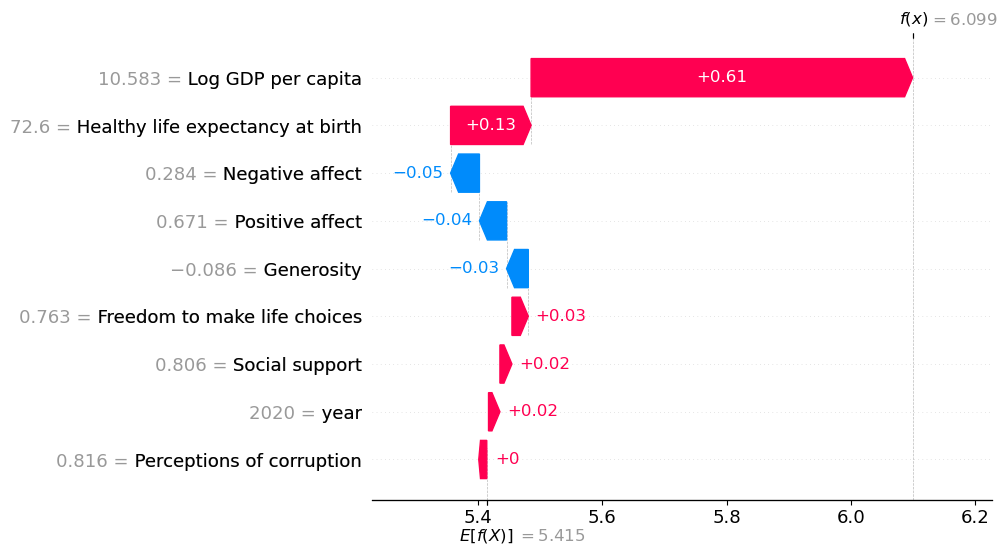

In [41]:
import shap
#Summarize the SHAP values for a specific prediction with lightgbm model
shap.plots.waterfall(shap_values_lgbm[100])

### Waterfall LightGBM Regressor shows how each feature contributes to the prediction for one sample.

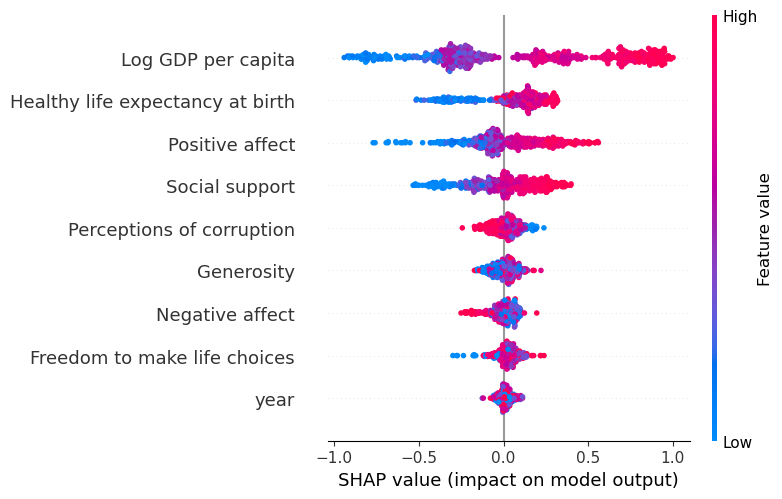

In [42]:
shap.summary_plot(shap_values_lgbm[:500], features_test[:500], show= False)


### Summary plot on LightGBM Regressor gives global overview of feature importance across many samples. This shows the whole dataset. 

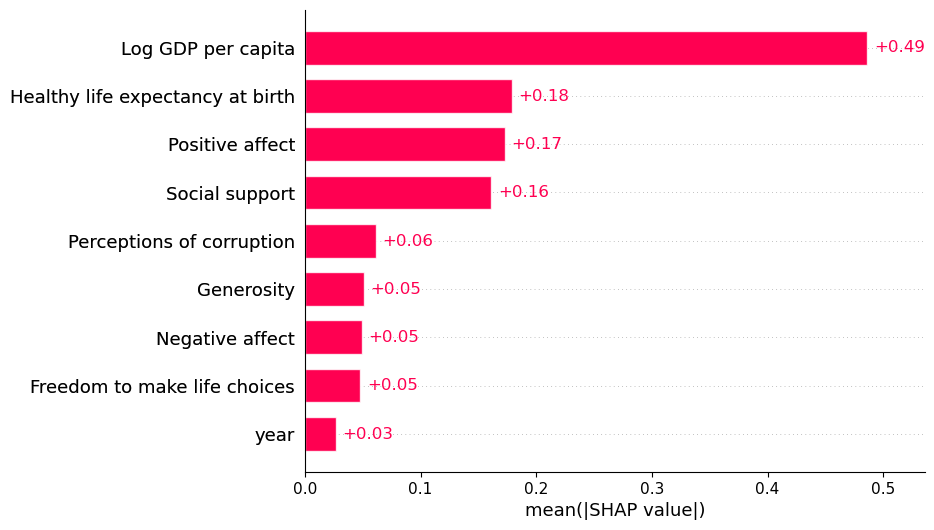

In [43]:
shap.plots.bar(shap_values_lgbm)

### Bar plot on LightGBM Regressor is showing the average absolute SHAP values for each features. Its helps to understand how each feature contributes to predictions on average.

In [44]:

model2 = CatBoostRegressor(n_estimators= 190, max_depth= 8).fit(features_train, target_train)

explainer = shap.Explainer(model2, features_train)
shap_values_cbr = explainer(features_test, check_additivity=False)


Learning rate set to 0.172173
0:	learn: 0.9903169	total: 9.1ms	remaining: 1.72s
1:	learn: 0.8790332	total: 13.5ms	remaining: 1.27s
2:	learn: 0.7876228	total: 19.5ms	remaining: 1.22s
3:	learn: 0.7154097	total: 24.3ms	remaining: 1.13s
4:	learn: 0.6540750	total: 31.4ms	remaining: 1.16s
5:	learn: 0.6068732	total: 40.6ms	remaining: 1.25s
6:	learn: 0.5697233	total: 49ms	remaining: 1.28s
7:	learn: 0.5352018	total: 55.2ms	remaining: 1.25s
8:	learn: 0.5106410	total: 61.6ms	remaining: 1.24s
9:	learn: 0.4911071	total: 67.6ms	remaining: 1.22s
10:	learn: 0.4724149	total: 72.5ms	remaining: 1.18s
11:	learn: 0.4561002	total: 78.9ms	remaining: 1.17s
12:	learn: 0.4430904	total: 84.4ms	remaining: 1.15s
13:	learn: 0.4333684	total: 89.1ms	remaining: 1.12s
14:	learn: 0.4252867	total: 95.8ms	remaining: 1.12s
15:	learn: 0.4165425	total: 101ms	remaining: 1.1s
16:	learn: 0.4101592	total: 107ms	remaining: 1.08s
17:	learn: 0.4037584	total: 113ms	remaining: 1.07s
18:	learn: 0.3962134	total: 118ms	remaining: 1.06s


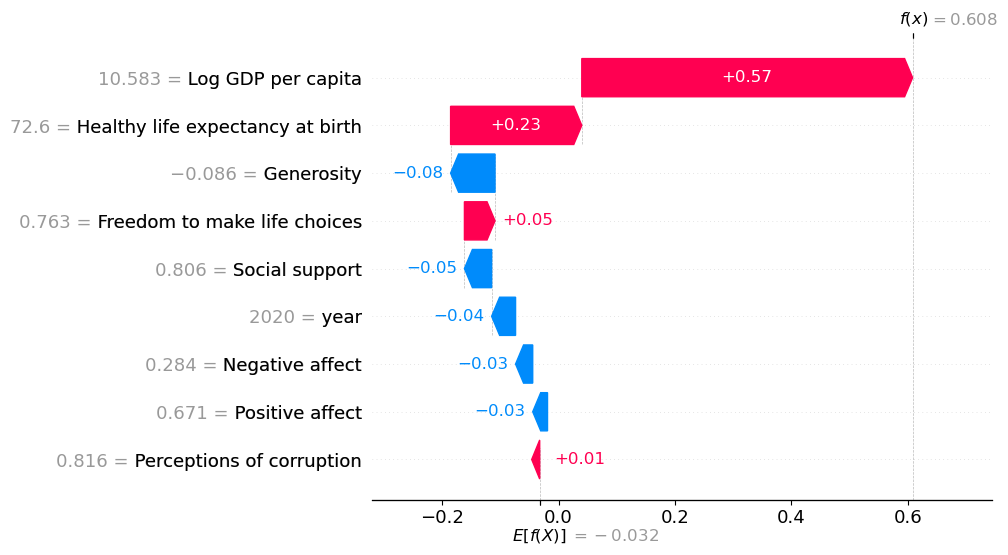

In [45]:
import shap
#Summarize the SHAP values for a specific prediction with catboost model
shap.plots.waterfall(shap_values_cbr[100])

### Waterfall CatBoost Regressor shows how each feature contributes to the prediction for one sample.

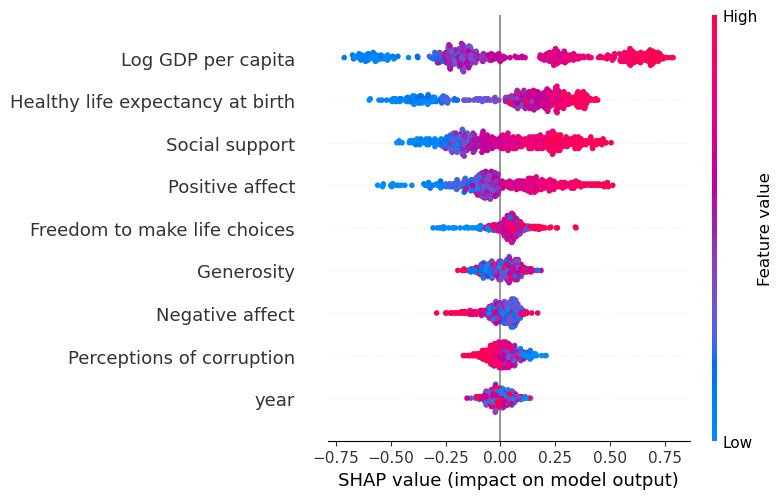

In [46]:
shap.summary_plot(shap_values_cbr[:500], features_test[:500], show= False)

### Summary plot on CatBoost Regressor gives global overview of feature importance across many samples. This shows the whole dataset. It can be seen that Log GDP per capita is most important according to our best model.

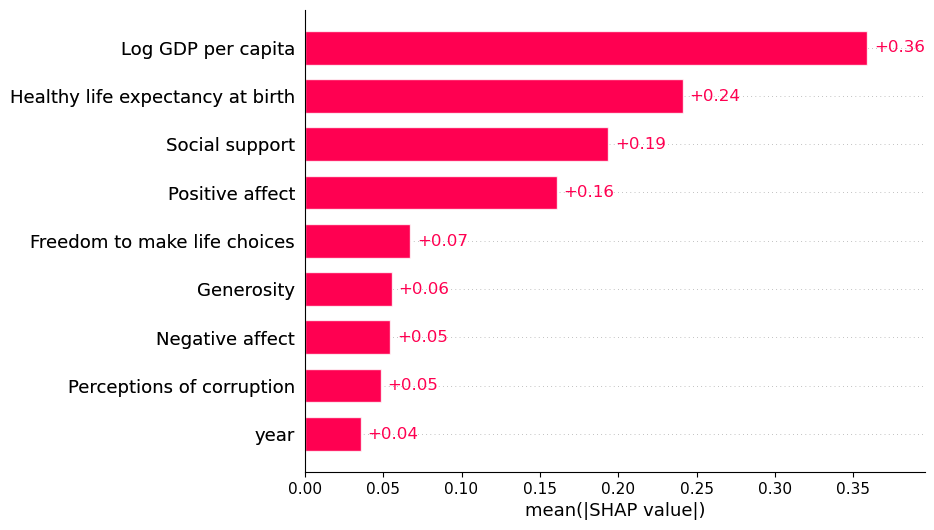

In [47]:
shap.plots.bar(shap_values_cbr)

 ### Bar plot on CatBoost Regressor is showing the average absolute SHAP values for each features. Its helps to understand how each feature contributes to predictions on average.